In [1]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from flora import FloraAdam
from adam import CustomAdam

from utils import get_mnist

# Training

In [2]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
input_size = 28 * 28
hidden_size = 1024
num_classes = 10
lr = 1e-5
seed = 0
epochs = 10_000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model_flora = SimpleNeuralNetwork(input_size, hidden_size, num_classes).to(device)
model_adam = SimpleNeuralNetwork(input_size, hidden_size, num_classes).to(device)

# Training step
loss_fn_flora = nn.CrossEntropyLoss().to(device)
loss_fn_adam = nn.CrossEntropyLoss().to(device)

# optimizer = FloraAdamD(model.parameters(), lr=5e-2, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)
optimizer_flora = FloraAdam(
    model_flora.parameters(),
    lr=lr,
    betas=(0.9, 0.999),
    eps=1e-8,
    rank=hidden_size // 4,
    kappa=100,
    seed=seed,
)
optimizer_adam = CustomAdam(
    model_adam.parameters(),
    lr=lr,
    betas=(0.9, 0.999),
    eps=1e-8,
)

# Store loss for plotting
loss_values_flora = []
loss_values_adam = []


Convert the dataset to a format suitable for PyTorch

In [4]:
train_dataset, validation_dataset, test_dataset = get_mnist()

In [5]:
def train_one_epoch(model, optimizer, loss_fn, batch_inputs, batch_labels, epoch_index, device=None):
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(batch_inputs)

    # Compute the loss and its gradients
    loss = loss_fn(outputs, batch_labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    return loss.item()

In [6]:
def train_model(model, epochs, train_dataset, validation_dataset, loss_fn, optimizer, device=None):
    best_vloss = 1_000_000.
    train_inputs = train_dataset['inputs'].to(device)
    train_labels = train_dataset['labels'].to(device)
    validation_inputs = validation_dataset['inputs'].to(device)
    validation_labels = validation_dataset['labels'].to(device)


    train_losses = []
    validation_losses = []
    for epoch in tqdm(range(epochs)):
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        train_loss = train_one_epoch(model, optimizer, loss_fn, train_inputs, train_labels, epoch, device=device)
        train_losses.append(train_loss)

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            # Make predictions for this batch
            voutputs = model(validation_inputs)
            validation_loss = loss_fn(voutputs, validation_labels)
            validation_losses.append(validation_loss.item())

        # Track best performance, and save the model's state
        # if validation_loss < best_vloss:
        #     best_vloss = validation_loss
        #     model_path = 'model_{}_{}'.format(timestamp, epoch)
        #     torch.save(model.state_dict(), model_path)

        epoch += 1

    return train_losses, validation_losses

In [7]:
def evaluate_model(model, test_dataset, device=None):
    inputs = test_dataset['inputs'].to(device)

    with torch.no_grad():
        outputs = model(inputs).argmax(dim=1)

    all_labels = test_dataset['labels']
    all_preds = outputs.cpu()

    assert len(all_labels) == len(all_preds)

    acc = accuracy_score(all_labels, all_preds)

    print('Accuracy: ', acc * 100, '%')

    return all_preds, all_labels, acc

In [8]:
train_losses_flora, validation_losses_flora = train_model(model_flora, epochs, train_dataset, validation_dataset, loss_fn_flora, optimizer_flora, device=device)
all_preds_flora, all_labels_flora, acc_flora = evaluate_model(model_flora, test_dataset, device=device)

100%|██████████| 10000/10000 [02:41<00:00, 61.92it/s]

Accuracy:  97.45 %


In [9]:
train_losses_adam, validation_losses_adam = train_model(model_adam, epochs, train_dataset, validation_dataset, loss_fn_adam, optimizer_adam, device=device)
all_preds_adam, all_labels_adam, acc_adam = evaluate_model(model_adam, test_dataset, device=device)

100%|██████████| 10000/10000 [02:42<00:00, 61.43it/s]


Accuracy:  97.94 %


In [10]:
# save the models
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save(model_flora.state_dict(), f"model_flora-{timestamp}.pth")
torch.save(model_adam.state_dict(), f"model_adam-{timestamp}.pth")

# Plot Training Curves

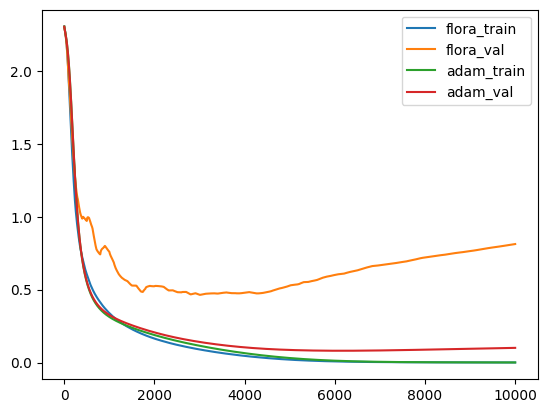

In [11]:
fig, ax = plt.subplots()
ax.plot(train_losses_flora, label='flora_train')
ax.plot(validation_losses_flora, label='flora_val')
ax.plot(train_losses_adam, label='adam_train')
ax.plot(validation_losses_adam, label='adam_val')
ax.legend()

# Plot weight histograms

In [12]:
def plot_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            fig, ax = plt.subplots()
            ax.hist(param.data.cpu().numpy().flatten(), bins=100, range=(-0.15, 0.15))
            ax.set_title(f'Weight distribution for {name}')
            ax.set_xlabel('Weight value')
            ax.set_ylabel('Frequency')
            ax.grid()

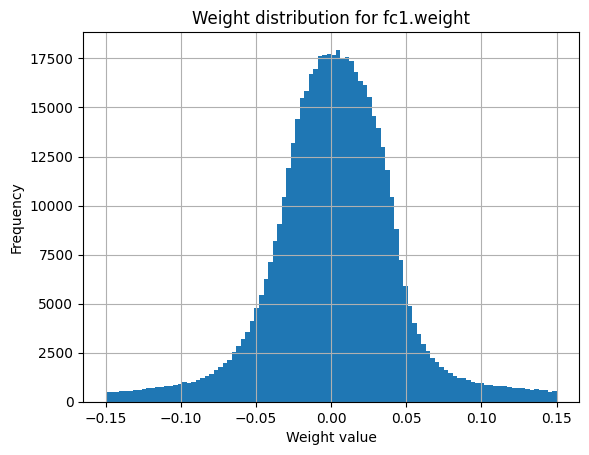

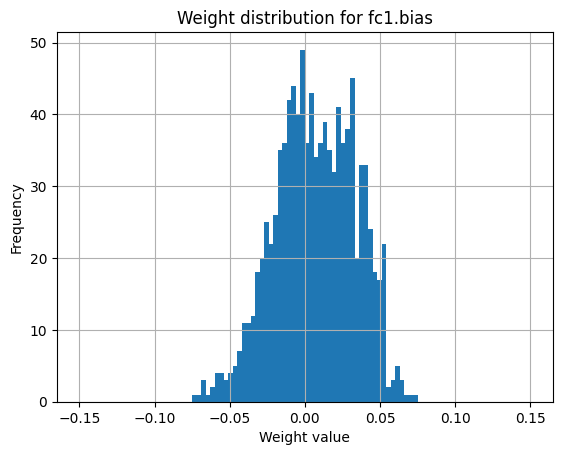

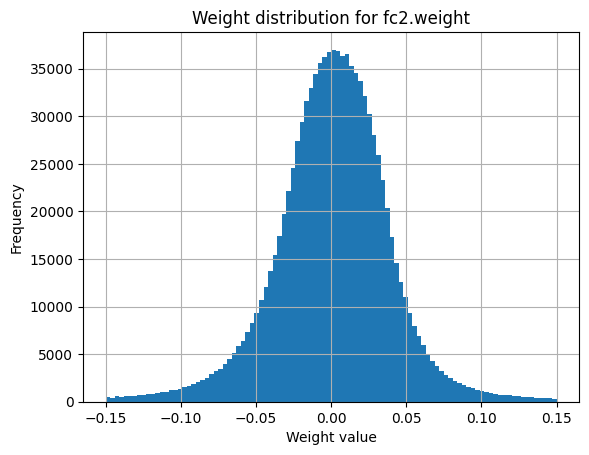

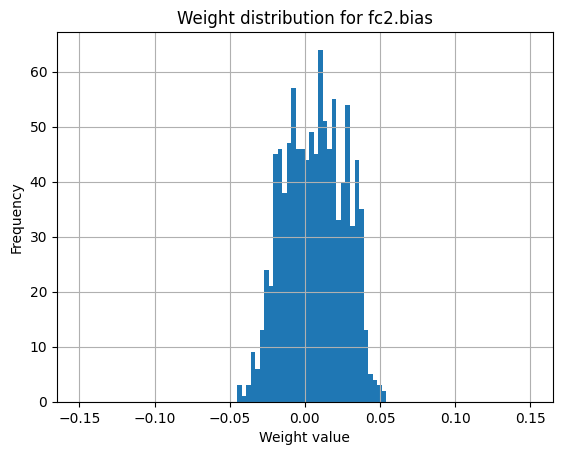

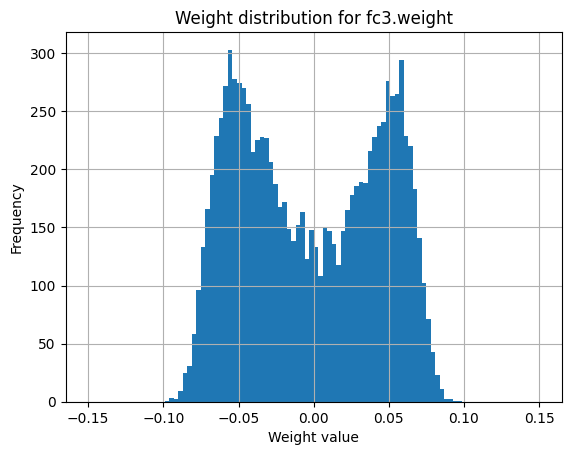

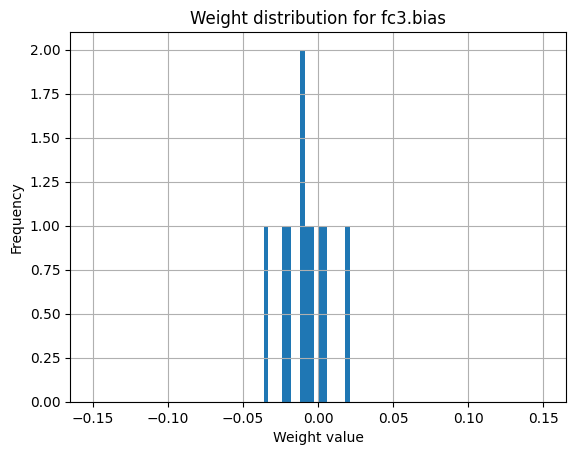

In [13]:
plot_weights(model_flora)

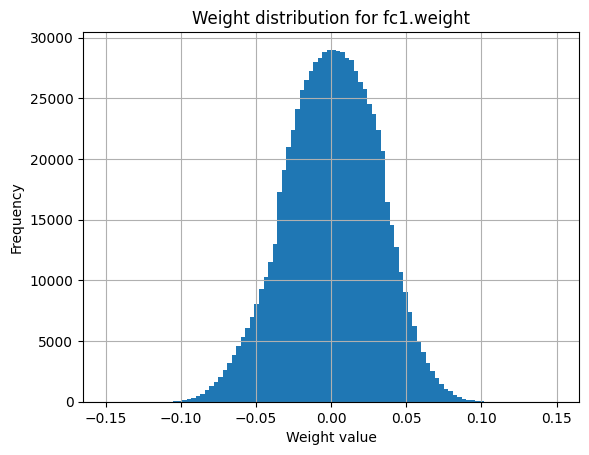

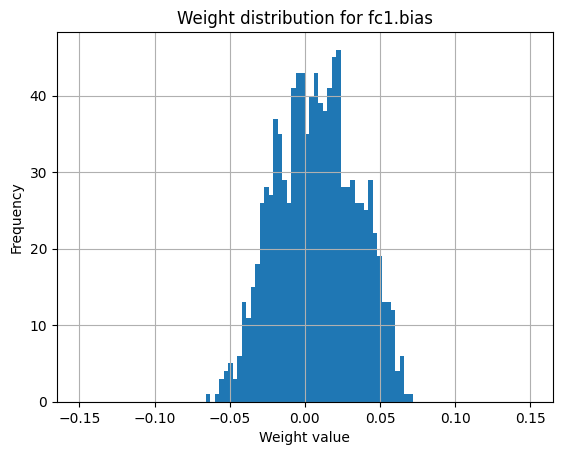

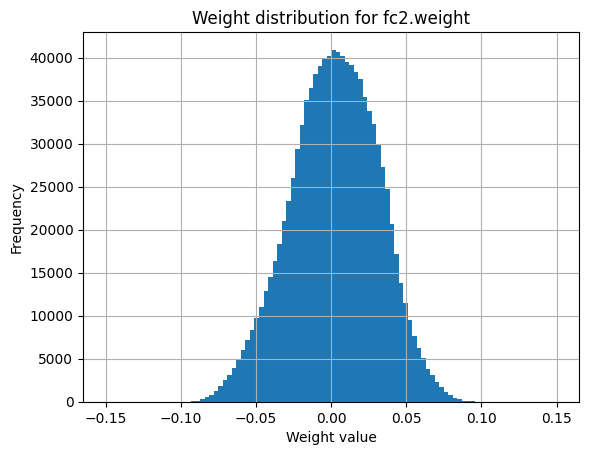

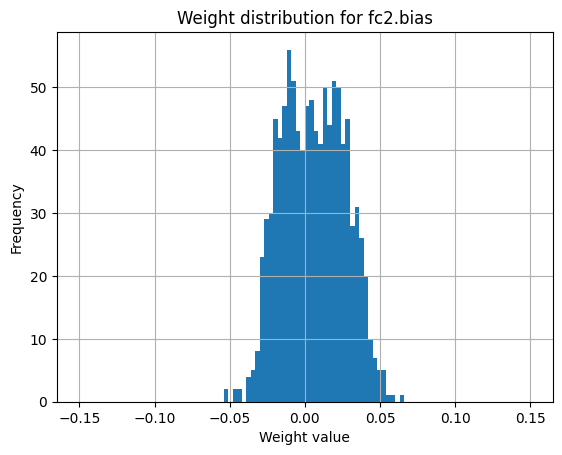

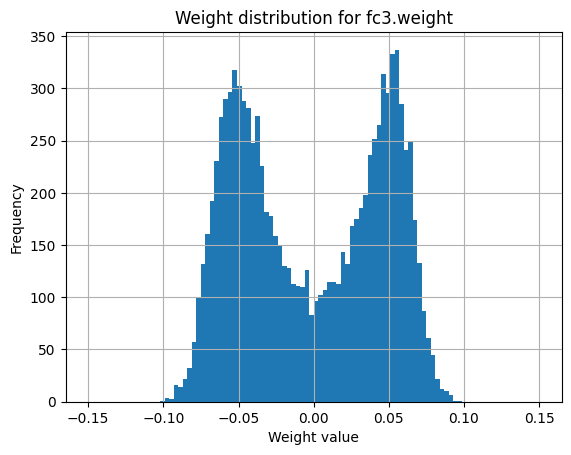

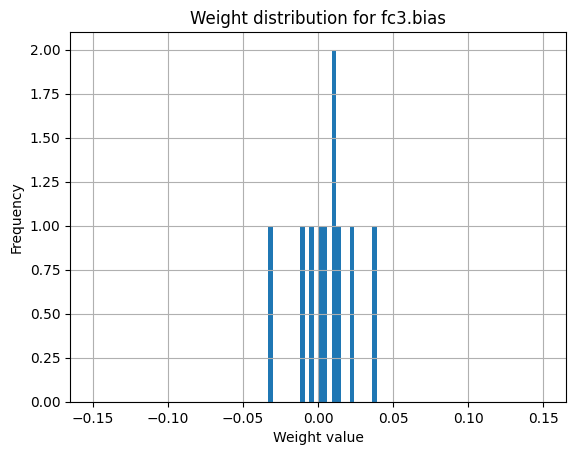

In [14]:
plot_weights(model_adam)